# Predicciones

In [ ]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.1 MB/s eta 0:00:00


In [ ]:
pip install pdfkit

In [ ]:
import numpy as np
import pandas as pd

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# import dtreeviz.trees as dtreeviz
import dtreeviz.trees as dt

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Importamos los datasets
dataset_hotels_test = pd.read_csv('https://github.com/joeldevel/data_tp1_odd/blob/main/hotels_test.csv?raw=true')
dataset_hotels_train = pd.read_csv('https://github.com/joeldevel/data_tp1_odd/blob/main/hotels_train.csv?raw=true')

#Objetivo

El objetivo de este checkpoint es predecir el valor del atributo is_canceled por medio del uso de los árboles de decisión. Antes de realizar esto, se harán todas las tareas de ingeniería de características correspondientes.

#Análisis exploratorio

No realizaremos un análisis exploratorio amplio ya que lo hicimos en el anterio checkpoint. Para ver el análisis explotorio con mas detalles, por favor revisar el proyecto llamado "Análisis exploratorio y procesamiento de datos" en mi repositorio de GitHub.

Listar la cantidad de filas y columnas que tiene el dataset de entrenamiento:

In [ ]:
dataset_hotels_train.shape

(61913, 32)

El dataset de entrenamiento contiene 61913 filas y 32 columnas.

In [ ]:
dataset_hotels_test.shape

(26535, 31)

El dataset de prueba contiene un total de 26535 filas y 31 columnas.

Columnas del dataset de entrenamiento:

In [ ]:
dataset_hotels_train.columns.tolist()

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled']

Columnas del dataset de prueba:

In [ ]:
dataset_hotels_test.columns.tolist()

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_date',
 'id']

Como se verá, el dataset de prueba es casi el mismo que el de entrenamiento. La única diferencia es que en el de prueba no esta la variable 'is_canceled' (Que es la variable a predecir).

# Preprocesamiento

Por pedido de los profesores, eliminamos la columna 'reservation_status_date' tanto el archivo de entrenamiento como tambien en el de test:

In [ ]:
dataset_hotels_train.drop(['reservation_status_date'], axis='columns', inplace=True)
dataset_hotels_test.drop(['reservation_status_date'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test_id = dataset_hotels_test['id'].copy()

Convertimos los valores de la variable 'agent' (Tanto en el archivo de entrenamiento como en el de prueba) en números de tipo entero (Antes de eso, se rellena los valores NAN con un cero). Despues de haber convertido los valores a datos de tipo entero, los convierte nuevamente a datos de tipo String:

In [ ]:
dataset_hotels_train['agent'] = dataset_hotels_train['agent'].fillna(0).astype('int').astype('str')
dataset_hotels_test['agent'] = dataset_hotels_test['agent'].fillna(0).astype('int').astype('str')

Eliminamos (Tanto en el archivo de entrenamiento como en el de prueba) las columnas/variables 'meal', 'is_repeated_guest', 'stays_in_weekend_nights', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
'arrival_date_day_of_month', 'id', 'previous_bookings_not_canceled'. El motivo es debido a que dichas variables, son innecesarias para la construcción del modelo.

In [ ]:
dataset_hotels_train.drop(['meal', 'is_repeated_guest','stays_in_weekend_nights','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month','id','previous_bookings_not_canceled'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test.drop(['meal', 'is_repeated_guest','stays_in_weekend_nights','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month','id','previous_bookings_not_canceled'], axis='columns', inplace=True)

Tanto en el dataset de entrenamiento como tambien en el de prueba calculamos
 la cantidad total de personas en cada estancia (O por cada fila) sumando el número de niños, adultos y bebes en esa estancia. Antes de lo anteriormente mencionado, rellenamos los valores faltantes de cada columna ('children', 'adults' y 'babies') y las reemplazamos con un cero.
Una vez construida la nueva columna a la que llamamos 'cant_personas' (Que será la columna con el total de personas por registro), eliminamos las columnas 'children', 'adults' y 'babies'.

In [ ]:
dataset_hotels_train['cant_personas'] = dataset_hotels_train['children'].fillna(0) + dataset_hotels_train['adults'].fillna(0) + dataset_hotels_train['babies'].fillna(0)
dataset_hotels_train.drop(['children', 'adults','babies'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test['cant_personas'] = dataset_hotels_test['children'].fillna(0) + dataset_hotels_test['adults'].fillna(0) + dataset_hotels_test['babies'].fillna(0)
dataset_hotels_test.drop(['children', 'adults','babies'], axis='columns', inplace=True)

Tanto en el dataset de entrenamiento como en el de prueba, realizamos imputación de datos (Relleno de valores faltantes) en las columnas 'company' y 'agent'. En la columna 'company', reemplazamos los valores faltantes con un valor llamado 'ninguno'. Mientras que en la columna 'agent', reemplazamos los valores faltantes con un valor llamado 'desconocida'.

In [ ]:
dataset_hotels_train['company'] = dataset_hotels_train['company'].fillna('ninguno')

In [ ]:
dataset_hotels_test['company'] = dataset_hotels_test['company'].fillna('ninguno')

In [ ]:
dataset_hotels_train['agent'] = dataset_hotels_train['agent'].fillna('desconocida')

In [ ]:
dataset_hotels_test['agent'] = dataset_hotels_test['agent'].fillna('desconocida')

In [ ]:
dataset_hotels_train.dtypes

hotel                           object
lead_time                        int64
stays_in_week_nights             int64
country                         object
market_segment                  object
distribution_channel            object
previous_cancellations           int64
reserved_room_type              object
assigned_room_type              object
booking_changes                  int64
deposit_type                    object
agent                           object
company                         object
days_in_waiting_list             int64
customer_type                   object
adr                            float64
required_car_parking_spaces      int64
total_of_special_requests        int64
is_canceled                      int64
cant_personas                  float64
dtype: object

In [ ]:
dataset_hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61913 entries, 0 to 61912
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        61913 non-null  object 
 1   lead_time                    61913 non-null  int64  
 2   stays_in_week_nights         61913 non-null  int64  
 3   country                      61692 non-null  object 
 4   market_segment               61913 non-null  object 
 5   distribution_channel         61913 non-null  object 
 6   previous_cancellations       61913 non-null  int64  
 7   reserved_room_type           61913 non-null  object 
 8   assigned_room_type           61913 non-null  object 
 9   booking_changes              61913 non-null  int64  
 10  deposit_type                 61913 non-null  object 
 11  agent                        61913 non-null  object 
 12  company                      61913 non-null  object 
 13  days_in_waiting_

##Generamos One Hot Encoding para recodificar las variables catégoricas ya que para este tipo de árboles de decision, solo aceptan variables numéricas como variables de entrada.

Generamos One hot Encoding para la variable hotel

In [ ]:
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['hotel'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['hotel'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['hotel'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['hotel'], axis='columns', inplace=True)

Genero One hot Encoding para la variable market_segment

In [ ]:
lista_market_segment_mayoritarios = dataset_hotels_train['market_segment'].value_counts().nlargest(5).index.tolist()
lista_market_segment_mayoritarios

['Online TA', 'Offline TA/TO', 'Groups', 'Direct', 'Corporate']

In [ ]:
dataset_hotels_train['market_segment'] = pd.Series(np.where(~dataset_hotels_train['market_segment'].isin(lista_market_segment_mayoritarios), 'otro market', dataset_hotels_train['market_segment']))
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['market_segment'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['market_segment'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test['market_segment'] = pd.Series(np.where(~dataset_hotels_test['market_segment'].isin(lista_market_segment_mayoritarios), 'otro market', dataset_hotels_test['market_segment']))
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['market_segment'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['market_segment'], axis='columns', inplace=True)

Genero One hot Encoding para la variable distribution_channel

In [ ]:
dataset_hotels_train['distribution_channel']= dataset_hotels_train['distribution_channel'].replace('Direct','direct_channel')
dataset_hotels_test['distribution_channel']= dataset_hotels_test['distribution_channel'].replace('Direct','direct_channel')

In [ ]:
lista_distribution_channel_mayoritarios = dataset_hotels_train['distribution_channel'].value_counts().nlargest(3).index.tolist()
lista_distribution_channel_mayoritarios

['TA/TO', 'direct_channel', 'Corporate']

In [ ]:
dataset_hotels_train['distribution_channel'] = pd.Series(np.where(~dataset_hotels_train['distribution_channel'].isin(lista_distribution_channel_mayoritarios), 'otro distribution channel', dataset_hotels_train['distribution_channel']))
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['distribution_channel'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['distribution_channel'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test['distribution_channel'] = pd.Series(np.where(~dataset_hotels_test['distribution_channel'].isin(lista_distribution_channel_mayoritarios), 'otro distribution channel', dataset_hotels_test['distribution_channel']))
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['distribution_channel'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['distribution_channel'], axis='columns', inplace=True)

Genero One hot Encoding para la variable assigned_room_type

In [ ]:
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['assigned_room_type'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['assigned_room_type'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['assigned_room_type'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['assigned_room_type'], axis='columns', inplace=True)

Genero One hot Encoding para la variable deposit_type

In [ ]:
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['deposit_type'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['deposit_type'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['deposit_type'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['deposit_type'], axis='columns', inplace=True)

Genero One hot Encoding para la variable customer_type

In [ ]:
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['customer_type'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['customer_type'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['customer_type'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['customer_type'], axis='columns', inplace=True)

Genero One hot Encoding para la variable agent

In [ ]:
lista_agent_mayoritarios = dataset_hotels_train['agent'].value_counts().nlargest(9).index.tolist()
lista_agent_mayoritarios

['9', '0', '240', '1', '14', '6', '7', '250', '241']

In [ ]:
dataset_hotels_train['agent'] = pd.Series(np.where(~dataset_hotels_train['agent'].isin(lista_agent_mayoritarios), 'otra agencia', dataset_hotels_train['agent']))
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['agent'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['agent'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test['agent'] = pd.Series(np.where(~dataset_hotels_test['agent'].isin(lista_agent_mayoritarios), 'otra agencia', dataset_hotels_test['agent']))
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['agent'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['agent'], axis='columns', inplace=True)

Genero One hot Encoding para la variable company

In [ ]:
lista_company_mayoritarios = dataset_hotels_train['company'].value_counts().nlargest(1).index.tolist()
lista_company_mayoritarios

['ninguno']

In [ ]:
dataset_hotels_train['company'] = pd.Series(np.where(~dataset_hotels_train['company'].isin(lista_company_mayoritarios), 'con compay', dataset_hotels_train['company']))
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['company'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['company'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test['company'] = pd.Series(np.where(~dataset_hotels_test['company'].isin(lista_company_mayoritarios), 'con compay', dataset_hotels_test['company']))
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['company'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['company'], axis='columns', inplace=True)

Genero One hot Encoding para la variable Country. Como son muchos paises y para no saturar de dimensiones los datos, agrupo los paises minoritarios en una nueva categoria.

In [ ]:
lista_paises_mayoritarios = dataset_hotels_train['country'].value_counts().nlargest(10).index.tolist()
lista_paises_mayoritarios

['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BRA', 'BEL', 'USA']

In [ ]:
dataset_hotels_train['country'] = pd.Series(np.where(~dataset_hotels_train['country'].isin(lista_paises_mayoritarios), 'Otro Pais', dataset_hotels_train['country']))
dataset_hotels_train = pd.concat([dataset_hotels_train, pd.get_dummies(dataset_hotels_train['country'], drop_first=True )], axis=1)
dataset_hotels_train.drop(['country'], axis='columns', inplace=True)

In [ ]:
dataset_hotels_test['country'] = pd.Series(np.where(~dataset_hotels_test['country'].isin(lista_paises_mayoritarios), 'Otro Pais', dataset_hotels_test['country']))
dataset_hotels_test = pd.concat([dataset_hotels_test, pd.get_dummies(dataset_hotels_test['country'], drop_first=True )], axis=1)
dataset_hotels_test.drop(['country'], axis='columns', inplace=True)

Basicamente, lo que hace el código de arriba (Tanto en el dataset de entrenamiento como tambien en el de prueba) es primero verificar cuales son los nombres de los primeros 10 paises con los recuentos mas altos de la columna 'country'. Una vez hecho eso, arma una lista con los 10 paises que mas recuento tienen. Luego, reemplazamos a los paises que NO estan en la lista de los paises mayoritarios y los ponemos como 'Otro Pais' dentro de la columna 'country'. Finalmente, despues de esto, realizamos el One Hot Encoding y luego, eliminamos la columna 'country'.

In [ ]:
list_columns = dataset_hotels_test.columns.to_list()

Mostramos las columnas que tiene el dataset de entrenamiento y que su vez NO las tiene el dataset de prueba:

In [ ]:
dataset_hotels_test.columns.symmetric_difference(dataset_hotels_train.columns)

Index(['L', 'is_canceled'], dtype='object')

Agregamos la columna 'L' al dataset de prueba y asignamos a todos los elementos de esa columna el valor cero:

In [ ]:
dataset_hotels_test['L'] = np.uint8(0)

Se vuelve a verificar y esta vez, la única columna que NO tiene el dataset de prueba pero si el dataset de entrenamiento es 'is_canceled' (Que es la variable a predecir en el dataset de prueba):

In [ ]:
dataset_hotels_train.columns.symmetric_difference(dataset_hotels_test.columns)

Index(['is_canceled'], dtype='object')

In [ ]:
dataset_hotels_train = dataset_hotels_train.reindex(sorted(dataset_hotels_train.columns), axis=1)
dataset_hotels_test = dataset_hotels_test.reindex(sorted(dataset_hotels_test.columns), axis=1)

PREPROCESAMIENTO HECHO

#Entrenamiento y predicción

In [ ]:
#Copiamos los valores de la columna 'is_canceled'. En resumen, creo un dataset de la variable target.
ds_hotels_y = dataset_hotels_train['is_canceled'].copy()

# Solo deja las columnas numericas
dataset_hotels_train = dataset_hotels_train.select_dtypes(include='number')

#Eliminamos la columna 'is_canceled' y agarramos el resto
ds_hotels_x = dataset_hotels_train.drop(['is_canceled'], axis='columns', inplace=False)

In [ ]:
# {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 8}; 0.8667527153266164

In [ ]:
ds_hotels_x

,1,14,240,241,250,6,7,9,B,BRA,...,direct_channel,lead_time,ninguno,otra agencia,otro distribution channel,otro market,previous_cancellations,required_car_parking_spaces,stays_in_week_nights,total_of_special_requests
0,0,0,0,0,0,0,0,1,0,0,...,0,49,1,0,0,0,0,0,2,1
1,0,0,0,0,0,0,0,0,0,0,...,1,4,1,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,25,1,0,0,0,0,0,1,2
3,0,0,0,0,0,0,0,0,0,0,...,0,26,1,1,0,0,0,0,5,0
4,0,0,0,0,0,0,0,0,0,0,...,0,104,1,1,0,0,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61908,0,0,1,0,0,0,0,0,0,0,...,0,24,1,0,0,0,0,0,2,1
61909,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
61910,0,0,0,0,0,0,0,0,0,0,...,0,10,0,0,0,1,0,0,2,0
61911,0,0,0,0,0,0,0,0,0,0,...,0,143,1,1,0,0,0,0,5,0


In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
import sklearn as sk
from sklearn.model_selection import StratifiedKFold, KFold #,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

In [ ]:
"""#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini'],
               'min_samples_leaf':[7],
               'min_samples_split': [7],
               'ccp_alpha':[1e-06],
               'max_depth':[19]}"""

"#Conjunto de parámetros que quiero usar\nparams_grid = {'criterion':['gini'],\n               'min_samples_leaf':[7],\n               'min_samples_split': [7],\n               'ccp_alpha':[1e-06],\n               'max_depth':[19]}"

In [ ]:
from sklearn.model_selection import GridSearchCV


#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini'],
               'min_samples_leaf':[7],
               'min_samples_split': [7],
               'ccp_alpha':[1e-06],
               'max_depth':[19]}
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#GridSearch CV
gridcv = GridSearchCV(estimator=base_tree ,
                      param_grid=params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv,
                      return_train_score='True',
                      verbose=1)

gridcv.fit(ds_hotels_x,ds_hotels_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [1e-06], 'criterion': ['gini'],
                         'max_depth': [19], 'min_samples_leaf': [7],
                         'min_samples_split': [7]},
             return_train_score='True', scoring=make_scorer(f1_score),
             verbose=1)

In [ ]:
#Mejores hiperparametros del arbol
print(gridcv.best_params_)
#Mejor métrica
print(gridcv.best_score_)
print(gridcv.best_estimator_)

{'ccp_alpha': 1e-06, 'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 7, 'min_samples_split': 7}
0.8395257178353359
DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=19, min_samples_leaf=7,
                       min_samples_split=7)


In [ ]:
#Importancia y reglas del Árbol con mejor Performance
from sklearn.tree import export_text
arbol=DecisionTreeClassifier().set_params(**gridcv.best_params_)
model = arbol.fit(ds_hotels_x,ds_hotels_y)

reglas = export_text(model, feature_names=ds_hotels_x.columns.to_list())
print(reglas)

|--- Non Refund <= 0.50
|   |--- lead_time <= 11.50
|   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |--- lead_time <= 7.50
|   |   |   |   |--- PRT <= 0.50
|   |   |   |   |   |--- 9 <= 0.50
|   |   |   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |   |   |--- 14 <= 0.50
|   |   |   |   |   |   |   |   |--- 240 <= 0.50
|   |   |   |   |   |   |   |   |   |--- otro distribution channel <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- cant_personas <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- cant_personas >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |--- otro distribution channel >  0.50
|   |   |   |   |   |   |   |   |   |   |--- adr <= 90.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- adr >  90.00
|   |   |   |   |   |   |   |   |   |   |   |--- t

##Arbol version resumida:

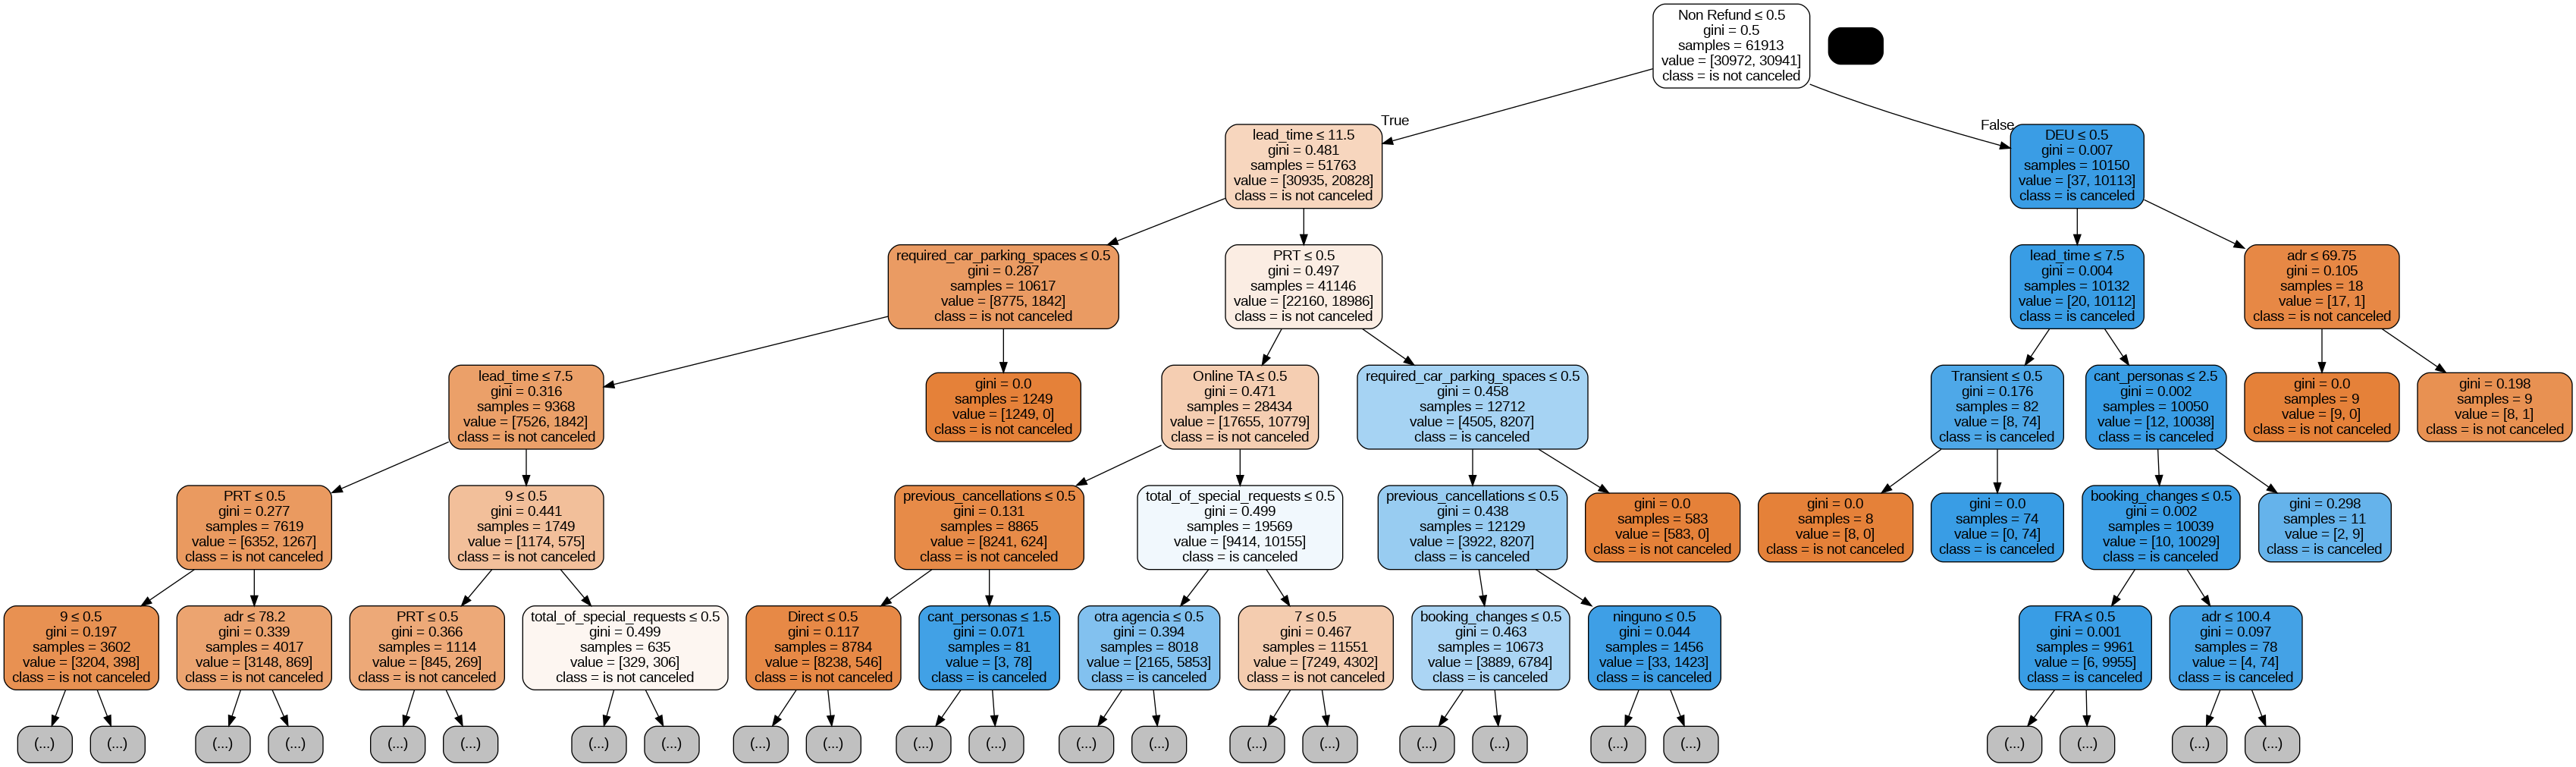

In [ ]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=ds_hotels_x.columns,
                class_names=['is not canceled','is canceled'],
                max_depth = 5)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Esta es la maxima profundidad en la que el gráfico del árbol es "visible"

- En la primera decision nuestro modelo de árbol decide por la categoria
Non Refound o no perteneciente al tipo de pago. El valor 1 representa la reserva cuando es totalmente cancelada. Dicha categoría se observa tener una impureza de gini de 0.5.
- Para la segunda decisión, para el grupo que SI tiene tipo de pago Non Refound se toma en cuenta el tiempo de espera de la reserva si es menor o igual a 11,5 con una impureza de gini de 0.481 para elegir esta variable y dividir al subconjunto. Para el caso de que el tipo de pago NO es Non Refound pregunta si la reserva pertenece al pais DEU, es decir Alemania, con una impureza de Gini de 0.007, es decir, muy baja al volver a dividir, quedando bastante caracterizada ya por estas 2 preguntas.
- En la rama mas a la derecha del árbol, se observan nodos hoja que poseen algunas de las predicciones del modelo (Tener que no son todas ya que el árbol posee mas nodos hoja de las que la imagen pueda y a su vez no visualizar). En estos nodos hoja vistos, se pueden ver que el modelo predice que hay por un lado, un total de 9 reservas que NO se cancelaron (Con un gini igual a cero) y por otro, un total de 8 reservas que NO se cancelaron y una que SI se canceló (Donde dicho nodo posee un gini igual a 0.198). Para ambos casos, el modelo predice que esto pasa cuando Non Refound <= 0.5, DEU <= 0.5 y que adr <= 69.75.

In [ ]:
ds_hotels_x['Non Refund']

0        0
1        0
2        0
3        1
4        0
        ..
61908    0
61909    0
61910    0
61911    1
61912    0
Name: Non Refund, Length: 61913, dtype: uint8

##Metricas:

F1-Score: 0.8760270278844018


Text(50.722222222222214, 0.5, 'True')

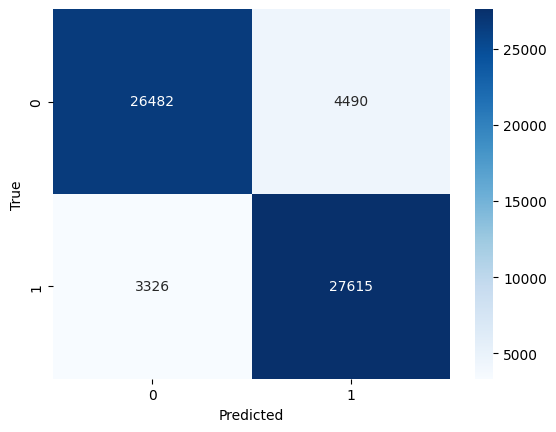

In [ ]:
#Evalúo el Arbol con los mejores hiperparámetros
from sklearn.metrics import confusion_matrix, classification_report , f1_score

#Hago predicción sobre el set de evaluacion
y_pred= gridcv.predict(ds_hotels_x)

#Arbol Reporte y Matriz de Confusion
#print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(ds_hotels_y, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(ds_hotels_y,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

- El Precision mide cuántos de los casos que el modelo ha identificado como positivos son realmente verdaderos positivos.

- El accuracy mide la proporción de instancias clasificadas correctamente, tanto positivas como negativas, con respecto al total de instancias.

- El recall mide cuántos de los casos positivos totales fueron realmente identificados por el modelo.

- El f1score combina tanto la precisión como el recall.


In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(ds_hotels_y,y_pred)
recall=recall_score(ds_hotels_y,y_pred)
f1=f1_score(ds_hotels_y,y_pred,)
precision=precision_score(ds_hotels_y,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8737583383134399
Recall: 0.8925050903332148
Precision: 0.860146394642579
f1 score: 0.8760270278844018


In [ ]:
from joblib import dump, load
dump(arbol, 'tree_model.joblib')

['tree_model.joblib']

#Export TEST to KAGGLE

In [ ]:
dataset_hotels_test.drop(['reserved_room_type'], axis='columns', inplace=True)

In [ ]:
gridcv.predict(dataset_hotels_test)

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
df_prediction = pd.DataFrame(zip(dataset_hotels_test_id,gridcv.predict(dataset_hotels_test))).rename(columns={0: "id", 1: "is_canceled"})
df_prediction

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
df_prediction.to_csv('entrega_prediction.csv', index=False)